# Milestone 2

In [1]:
# imports 
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from scripts import *

### I. Data Prepration

In [2]:
# Read the data
data_path = './data'  
images, labels = data_reader(data_path)

In [3]:
len(images)

455

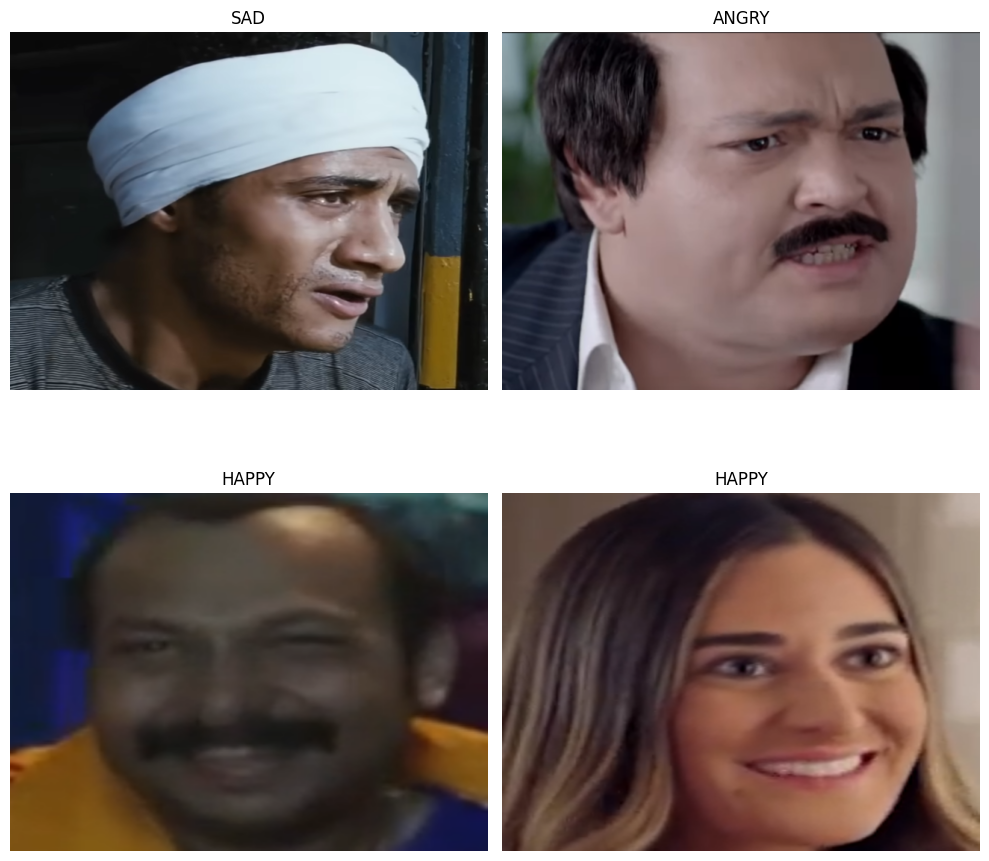

In [4]:
# View 4 random images and their titles
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(images))
    ax.imshow(images[idx])
    ax.set_title(labels[idx])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [5]:
# Preprocess the images 
train_tuple, val_tuple, test_tuple = data_preperator((images, labels))

train_data, train_labels = train_tuple
val_data, val_labels = val_tuple
test_data, test_labels = test_tuple

train_data.shape, train_labels.shape, val_data.shape, val_labels.shape, test_data.shape, test_labels.shape

((318, 512, 512, 3),
 (318,),
 (91, 512, 512, 3),
 (91,),
 (46, 512, 512, 3),
 (46,))

### II.First Model

In [6]:
# Predefined filters
import numpy as np

base_a = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
])

base_b = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
])

base_c = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

base_d = np.array([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]
])

base_e = np.array([
    [ 0, -1,  0],
    [-1,  5, -1],
    [ 0, -1,  0]
])

filter_a = np.stack([base_a]*3, axis=-1)
filter_b = np.stack([base_b]*3, axis=-1)
filter_c = np.stack([base_c]*3, axis=-1)
filter_d = np.stack([base_d]*3, axis=-1)
filter_e = np.stack([base_e]*3, axis=-1)


filters = [filter_a, filter_b, filter_c, filter_d, filter_e]

In [7]:
# Testing ConvLayer with Random filters
conv_layer = ConvLayer(4, (3, 3, 3))

output = conv_layer.forward(train_data[0])
output.shape

(510, 510, 4)

In [8]:
# Visualize the output of the convolutional layer
conv_layer = ConvLayer(5, (3, 3, 3), filter_weights=filters)

output = conv_layer.forward(train_data[0])
output.shape

(510, 510, 5)

In [9]:
# Testing the pooling layer
pooling_layer = PoolingLayer(pooling_type='MAX', pool_size=(2, 2))

output = pooling_layer.forward(train_data[0])
output.shape

(256, 256, 3)

### III. Second Model

In [10]:
# Test second_model is working
second_model = SecondModel()

example_image = torch.tensor(train_data[0], dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

output = second_model(example_image)

print("Output shape:", output.shape)
print("Output:", output)

Output shape: torch.Size([1, 4])
Output: tensor([[ 0.5039, -0.2212, -0.1214, -0.8045]], grad_fn=<AddmmBackward0>)


In [11]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Convert data to PyTorch tensors and move to device
train_data_tensor = torch.tensor(train_data, dtype=torch.float32).permute(0, 3, 1, 2)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)

val_data_tensor = torch.tensor(val_data, dtype=torch.float32).permute(0, 3, 1, 2)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)

test_data_tensor = torch.tensor(test_data, dtype=torch.float32).permute(0, 3, 1, 2)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create Datasets and Dataloaders
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_data_tensor, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)




Using device: cuda


In [12]:
def training(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    model.train()
    # Metrics storage
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = correct / total
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = val_correct / val_total
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.4f}')


In [13]:
# Initialize model and move to GPU
model = SecondModel().to(device)
# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

training(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch [1/20], Train Loss: 1.3060, Train Acc: 0.3774, Val Loss: 1.4138, Val Acc: 0.2527
Epoch [2/20], Train Loss: 1.1456, Train Acc: 0.5314, Val Loss: 1.5009, Val Acc: 0.2527
Epoch [3/20], Train Loss: 1.0540, Train Acc: 0.5975, Val Loss: 1.4386, Val Acc: 0.3626
Epoch [4/20], Train Loss: 0.9601, Train Acc: 0.6698, Val Loss: 1.3190, Val Acc: 0.3846
Epoch [5/20], Train Loss: 0.8892, Train Acc: 0.7484, Val Loss: 1.3375, Val Acc: 0.3516
Epoch [6/20], Train Loss: 0.8375, Train Acc: 0.7484, Val Loss: 1.2016, Val Acc: 0.4725
Epoch [7/20], Train Loss: 0.7626, Train Acc: 0.8113, Val Loss: 1.1876, Val Acc: 0.4396
Epoch [8/20], Train Loss: 0.6555, Train Acc: 0.8616, Val Loss: 1.1718, Val Acc: 0.5275
Epoch [9/20], Train Loss: 0.5833, Train Acc: 0.8899, Val Loss: 1.1391, Val Acc: 0.5385
Epoch [10/20], Train Loss: 0.5007, Train Acc: 0.9403, Val Loss: 1.1952, Val Acc: 0.5055
Epoch [11/20], Train Loss: 0.4684, Train Acc: 0.9277, Val Loss: 1.1352, Val Acc: 0.4945
Epoch [12/20], Train Loss: 0.4271, Train 

In [25]:
import torchvision.models as models
from torch import nn
from torchvision import transforms


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def get_pretrained_model(num_classes=4):
    model = models.resnet18(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False  

    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    return model


# Resize and normalize the images for pretrained models like ResNet
transform = transforms.Compose([
    transforms.ToPILImage(),  
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])




model = get_pretrained_model(num_classes=4).to(device)
train_data_tensor = torch.stack([
    transform(img) for img in train_data  
])

val_data_tensor = torch.stack([
    transform(img) for img in val_data
])

train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_data_tensor, val_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50
training(model, train_loader, val_loader, criterion, optimizer, num_epochs)



Using device: cuda


c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50], Train Loss: 1.4150, Train Acc: 0.2736, Val Loss: 1.3268, Val Acc: 0.3626
Epoch [2/50], Train Loss: 1.2655, Train Acc: 0.4308, Val Loss: 1.2477, Val Acc: 0.4396
Epoch [3/50], Train Loss: 1.1432, Train Acc: 0.5723, Val Loss: 1.1820, Val Acc: 0.5165
Epoch [4/50], Train Loss: 1.0500, Train Acc: 0.6038, Val Loss: 1.1425, Val Acc: 0.5275
Epoch [5/50], Train Loss: 0.9804, Train Acc: 0.6447, Val Loss: 1.0904, Val Acc: 0.5385
Epoch [6/50], Train Loss: 0.9015, Train Acc: 0.7044, Val Loss: 1.0707, Val Acc: 0.5495
Epoch [7/50], Train Loss: 0.8826, Train Acc: 0.7107, Val Loss: 1.0354, Val Acc: 0.5495
Epoch [8/50], Train Loss: 0.8429, Train Acc: 0.7138, Val Loss: 0.9989, Val Acc: 0.5824
Epoch [9/50], Train Loss: 0.8049, Train Acc: 0.7296, Val Loss: 0.9773, Val Acc: 0.5824
Epoch [10/50], Train Loss: 0.7455, Train Acc: 0.7799, Val Loss: 0.9559, Val Acc: 0.6154
Epoch [11/50], Train Loss: 0.7285, Train Acc: 0.7893, Val Loss: 0.9352, Val Acc: 0.6154
Epoch [12/50], Train Loss: 0.6976, Train 